<a href="https://colab.research.google.com/github/shubhangshirolawala/FlashAttention/blob/main/demo_flash_attention_minimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
'''
Make sure your runtime has a GPU enabled.
'''
# For building CUDA
!pip install Ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 7.0 MB/s eta 0:00:00


In [6]:
import os
import math
import torch
from torch.nn import functional as F
from torch.utils.cpp_extension import load_inline

cuda_src = r"""
extern "C"
__global__ void forward_kernel(const float* __restrict__ Q,
                               const float* __restrict__ K,
                               const float* __restrict__ V,
                               const int B, const int nh,
                               const int N, const int d,
                               const int Tc, const int Tr,
                               const int Bc, const int Br,
                               const float softmax_scale,
                               float* __restrict__ l,
                               float* __restrict__ m,
                               float* __restrict__ O) {

    const int b = blockIdx.x;   // batch index
    const int h = blockIdx.y;   // head index
    const int tx = threadIdx.x; // thread index within block

    // compute base offsets for this (batch, head)
    const long long head_stride = (long long)N * d;
    const long long bh_offset = ((long long)b * nh + h) * head_stride;
    const long long lm_offset = ((long long)b * nh + h) * N;

    extern __shared__ float sram[];
    float* Qi = sram;
    float* Kj = Qi + (size_t)Br * d;
    float* Vj = Kj + (size_t)Bc * d;
    float* S  = Vj + (size_t)Bc * d;

    for (int j = 0; j < Tc; ++j) {
        int Kj_row_start = j * Bc;
        // load Kj, Vj
        for (int idx = tx; idx < Bc * d; idx += blockDim.x) {
            int row = idx / d;
            int col = idx % d;
            int global_row = Kj_row_start + row;
            float valK = 0.0f, valV = 0.0f;
            if (global_row < N) {
                long long base = bh_offset + (long long)global_row * d + col;
                valK = K[base];
                valV = V[base];
            }
            Kj[row * d + col] = valK;
            Vj[row * d + col] = valV;
        }
        __syncthreads();

        for (int i = 0; i < Tr; ++i) {
            int Qi_row_start = i * Br;
            // load Qi
            for (int idx = tx; idx < Br * d; idx += blockDim.x) {
                int row = idx / d;
                int col = idx % d;
                int global_row = Qi_row_start + row;
                float valQ = 0.0f;
                if (global_row < N) {
                    long long base = bh_offset + (long long)global_row * d + col;
                    valQ = Q[base];
                }
                Qi[row * d + col] = valQ;
            }
            __syncthreads();

            for (int r = tx; r < Br; r += blockDim.x) {
                int q_row = Qi_row_start + r;
                if (q_row >= N) continue;

                // compute QK^T
                float row_m = -1e20f;
                for (int y = 0; y < Bc; ++y) {
                    float dot = 0.0f;
                    for (int z = 0; z < d; ++z) {
                        dot += Qi[r * d + z] * Kj[y * d + z];
                    }
                    float scaled = dot * softmax_scale;
                    S[r * Bc + y] = scaled;
                    if (scaled > row_m) row_m = scaled;
                }

                // softmax
                float row_l = 0.0f;
                for (int y = 0; y < Bc; ++y) {
                    float ex = expf(S[r * Bc + y] - row_m);
                    S[r * Bc + y] = ex;
                    row_l += ex;
                }

                // merge with previous results
                long long ml_index = lm_offset + q_row;
                float row_m_prev = m[ml_index];
                float row_l_prev = l[ml_index];
                float row_m_new = fmaxf(row_m_prev, row_m);
                float a = expf(row_m_prev - row_m_new);
                float c = expf(row_m - row_m_new);
                float row_l_new = a * row_l_prev + c * row_l;

                // output accumulation
                for (int col = 0; col < d; ++col) {
                    float pv = 0.0f;
                    for (int y = 0; y < Bc; ++y) {
                        pv += S[r * Bc + y] * Vj[y * d + col];
                    }
                    long long out_index = bh_offset + (long long)q_row * d + col;
                    float prevO = O[out_index];
                    float newO = (a * row_l_prev * prevO + c * pv) / row_l_new;
                    O[out_index] = newO;
                }

                // store updated m, l
                m[ml_index] = row_m_new;
                l[ml_index] = row_l_new;
            }
            __syncthreads();
        }
        __syncthreads();
    }
}

torch::Tensor forward(torch::Tensor Q, torch::Tensor K, torch::Tensor V) {
    const int B = Q.size(0);
    const int nh = Q.size(1);
    const int N = Q.size(2);
    const int d = Q.size(3);

    const int Bc = 32;
    const int Br = 32;
    const int Tc = (N + Bc - 1) / Bc;
    const int Tr = (N + Br - 1) / Br;
    const float softmax_scale = 1.0 / sqrtf((float)d);

    auto O = torch::zeros_like(Q);
    auto l = torch::zeros({B, nh, N}, Q.options());
    auto m = torch::full({B, nh, N}, -1e20f, Q.options());

    int sram_size = ((Br * d) + 2 * (Bc * d) + (Br * Bc)) * sizeof(float);

    dim3 grid(B, nh);
    dim3 block(max(Br, Bc));
    forward_kernel<<<grid, block, sram_size>>>(
        Q.data_ptr<float>(), K.data_ptr<float>(), V.data_ptr<float>(),
        B, nh, N, d, Tc, Tr, Bc, Br, softmax_scale,
        l.data_ptr<float>(), m.data_ptr<float>(), O.data_ptr<float>()
    );

    cudaDeviceSynchronize();
    return O;
}
"""

cpp_src = "torch::Tensor forward(torch::Tensor Q, torch::Tensor K, torch::Tensor V);"

build_dir = "cuda"
os.makedirs(build_dir, exist_ok=True)

minimal_attn = load_inline(
    name="minimal_flash_attn",
    cpp_sources=cpp_src,
    cuda_sources=cuda_src,
    functions=["forward"],
    with_cuda=True,
    extra_cuda_cflags=["-O3"],
    build_directory=f"./{build_dir}",
)

W1030 07:54:21.876000 515 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1030 07:54:21.876000 515 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


In [22]:
batch_size = 1
n_head = 1
seq_len = 8
head_embd = 4

q = torch.randn(batch_size, n_head, seq_len, head_embd).cuda()
k = torch.randn(batch_size, n_head, seq_len, head_embd).cuda()
v = torch.randn(batch_size, n_head, seq_len, head_embd).cuda()

print('=== profiling manual attention ===')

# Our minimal flash attention needs to be faster than this.
def manual_attn(q, k, v):
    att = (q @ k.transpose(-2, -1) * (1.0 / math.sqrt(k.size(-1))))
    att = F.softmax(att, dim=-1)
    y = att @ v
    return y

with torch.autograd.profiler.profile(use_cuda=True) as prof:
    manual_result = manual_attn(q, k, v)


print(prof.key_averages().table(sort_by='cuda_time_total', row_limit=10))

print('=== profiling minimal flash attention === ')

with torch.autograd.profiler.profile(use_cuda=True) as prof:
    minimal_result = minimal_attn.forward(q, k, v)
print(prof.key_averages().table(sort_by='cuda_time_total', row_limit=10))

print('attn values sanity check:', torch.allclose(minimal_result, manual_result, rtol=0, atol=1e-02))
# print(minimal_result)
# print(manual_result)

=== profiling manual attention ===
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul        11.81%      89.082us        67.52%     509.490us     254.745us      93.000us        12.60%     515.000us     257.500us             2  
                                              aten::bmm        28.48%     214.886us        34.13%     257.564us     128.782us     270.000us        36.59%     270.000us     

/tmp/ipython-input-659295076.py:19: FutureWarning: The attribute `use_cuda` will be deprecated soon, please use ``use_device = 'cuda'`` instead.
  with torch.autograd.profiler.profile(use_cuda=True) as prof:
/tmp/ipython-input-659295076.py:27: FutureWarning: The attribute `use_cuda` will be deprecated soon, please use ``use_device = 'cuda'`` instead.
  with torch.autograd.profiler.profile(use_cuda=True) as prof:


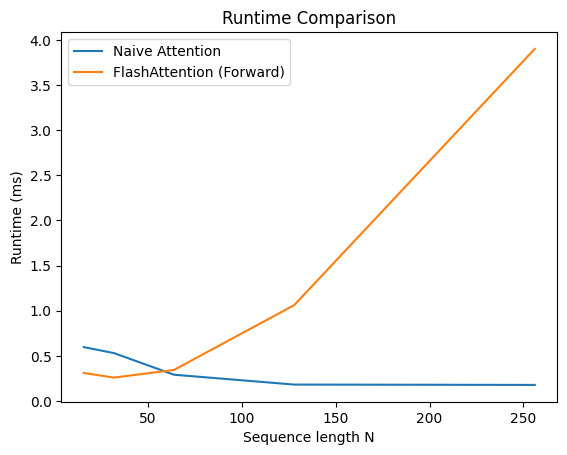

In [27]:
import torch, math, time
import matplotlib.pyplot as plt

lens = [16,32,64,128,256]
times_flash, times_manual = [], []

## at higher seq length the naive pytorch matmul will be faster since in the implementation we are using each thread for each row which makes it slow. The actual paper implementation is different
for N in lens:
    q = torch.randn(1, 1, N, 8, device="cuda")
    k = torch.randn(1, 1, N, 8, device="cuda")
    v = torch.randn(1, 1, N, 8, device="cuda")

    torch.cuda.synchronize()
    t0 = time.time()
    manual_attn(q, k, v)
    torch.cuda.synchronize()
    times_manual.append((time.time()-t0)*1000)

    torch.cuda.synchronize()
    t0 = time.time()
    minimal_attn.forward(q, k, v)
    torch.cuda.synchronize()
    times_flash.append((time.time()-t0)*1000)

plt.plot(lens, times_manual, label="Naive Attention")
plt.plot(lens, times_flash, label="FlashAttention (Forward)")
plt.xlabel("Sequence length N")
plt.ylabel("Runtime (ms)")
plt.legend()
plt.title("Runtime Comparison")
plt.show()


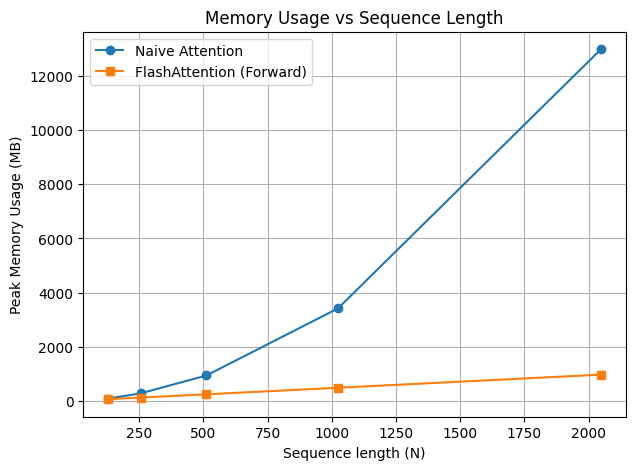

In [11]:
import torch
import matplotlib.pyplot as plt

lens = [128, 256, 512, 1024, 2048]
mem_manual, mem_flash = [], []

for N in lens:
    q = torch.randn(32, 12, N, 64, device="cuda")
    k = torch.randn(32, 12, N, 64, device="cuda")
    v = torch.randn(32, 12, N, 64, device="cuda")

    # PyTorch naive attention
    torch.cuda.reset_peak_memory_stats()
    _ = manual_attn(q, k, v)
    torch.cuda.synchronize()
    mem_manual.append(torch.cuda.max_memory_allocated() / (1024 ** 2))  # in MB

    # FlashAttention forward
    torch.cuda.reset_peak_memory_stats()
    _ = minimal_attn.forward(q, k, v)
    torch.cuda.synchronize()
    mem_flash.append(torch.cuda.max_memory_allocated() / (1024 ** 2))

plt.figure(figsize=(7,5))
plt.plot(lens, mem_manual, 'o-', label='Naive Attention')
plt.plot(lens, mem_flash, 's-', label='FlashAttention (Forward)')
plt.xlabel("Sequence length (N)")
plt.ylabel("Peak Memory Usage (MB)")
plt.title("Memory Usage vs Sequence Length")
plt.legend()
plt.grid(True)
plt.show()


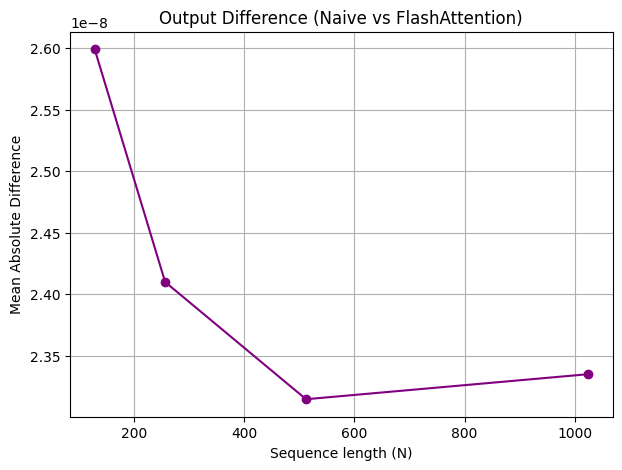

In [28]:
import torch, math
import matplotlib.pyplot as plt

lens = [128, 256, 512, 1024]
diffs = []

for N in lens:
    q = torch.randn(1, 2, N, 64, device="cuda")
    k = torch.randn(1, 2, N, 64, device="cuda")
    v = torch.randn(1, 2, N, 64, device="cuda")

    out_manual = manual_attn(q, k, v)
    out_flash = minimal_attn.forward(q, k, v)
    diff = torch.abs(out_manual - out_flash).mean().item()
    diffs.append(diff)

plt.figure(figsize=(7,5))
plt.plot(lens, diffs, 'o-', color='purple')
plt.xlabel("Sequence length (N)")
plt.ylabel("Mean Absolute Difference")
plt.title("Output Difference (Naive vs FlashAttention)")
plt.grid(True)
plt.show()
